# BLEEERGH

## Model

For now, I assume all sensors are GPS-synchronized, like in the first round of the [AICrowd competition](https://www.aicrowd.com/challenges/cyd-campus-aircraft-localization-competition)

The competitors found that, despite the "synchronization", the clocks needed to be adjusted with a constant offset.

To make this model more suitable for the later steps of this thesis, I assume that this offset is not an exact constant, but follows a normal distribution. This way, (un-)certainty of the exact offset can be modeled.

## Steps

1. Use known aircraft locations to calculate LocaRDS Sensor time offset distributions
2. Use estimated sensor time offset distributions to estimate aircraft locations on test set
3. Use estimated aircraft locations to estimate sensor time offset distributions for new sensors
4. Repeat steps 2 and 3 every day

## Data

The LocaRDS Data is in the following format:

- set_X_sensors.csv:

| serial | latitude | longitude | height | type | good |
|--------|----------|-----------|--------|------|------|

- set_X.csv:

| id | timeAtServer | aircraft | latitude | longitude | baroAltitude | geoAltitude | numMeasurements | measurements |
|----|--------------|----------|----------|-----------|--------------|-------------|-----------------|--------------|

- measurements (from set_X.csv):
    
| sensorID | timestamp | RSSI |
|----------|-----------|------|

In [8]:
import pandas as pd
import numpy as np

sensors = pd.read_csv("data/locards/set_1_sensors.csv")
msgs = pd.read_csv("data/locards/set_1.csv")

print(sensors.shape)
display(sensors.head(3))

print(msgs.shape)
display(msgs.head(3))

(716, 6)


,serial,latitude,longitude,height,type,good
0,1,46.681067,7.665313,680.9232,SBS-3,False
1,2,40.337042,-3.770206,735.7872,SBS-3,False
2,3,0.000000,0.000000,0.0000,SBS-3,False


(6457542, 9)


,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.0,304,52.378876,-0.659866,6355.08,6286.5,4,"[[208,962354640,98],[466,37145248250,178],[677..."
1,2,0.0,2671,42.287201,1.798137,9144.00,8915.4,4,"[[150,968341093,82],[552,29137895750,62],[434,..."
2,3,0.0,1940,47.052200,5.903641,10972.80,10820.4,2,"[[470,982753933,38],[499,6026974083.33333,30]]"


### Filter sensors

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

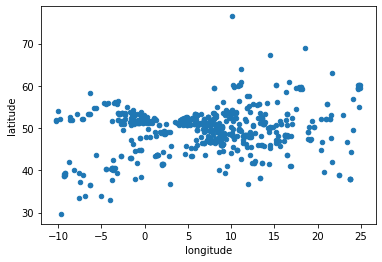

In [15]:
sensors = sensors[~(sensors['latitude'] < 20)]
sensors = sensors[~(sensors['longitude'] < -15)]

sensors.plot.scatter('longitude', 'latitude')

In [52]:
# assert that the sensors are all (indirectly) connected. If not, time offset estimation will not work
from collections import defaultdict
from tqdm import tqdm

print("Building graph...")

graph = defaultdict(set)
for index, msg in tqdm(msgs[msgs["numMeasurements"] >= 3].iterrows(), total=msgs[msgs["numMeasurements"] >= 3].shape[0]):
    sensor_serials = list()
    for measurement in eval(msg["measurements"]):
        sensor_serials.append(measurement[0])
    
    for i in range(len(sensor_serials)):
        for j in range(i+1, len(sensor_serials)):
                graph[sensor_serials[i]].add(sensor_serials[j])
                graph[sensor_serials[j]].add(sensor_serials[i])

print("Graph built")


Building graph...


100%|██████████| 4487070/4487070 [07:58<00:00, 9386.75it/s] 

Graph built


In [53]:
# dfs
component_sizes = [0]
#print(graph)
print(len(graph))
visited = set()
for ind in graph:
    if ind in visited:
        continue

    to_visit = [ind]
    while len(to_visit):
        top = to_visit.pop()
        if top in visited:
            continue
        visited.add(top)
        to_visit.extend(graph[top])

    component_sizes.append(len(visited) - component_sizes[-1])
    #print(len(visited))
    #print(sensors.shape[0])

print("Graph component sizes:", component_sizes[1:])

311
Graph component sizes: [300, 11]


In [33]:
from geopy import distance


sensor_deltas = defaultdict(list)

for index, msg in msgs.iterrows():
    location = (msg["latitude"], msg["longitude"])
    for measurement in eval(msg["measurements"]):
        sensor_location = sensors.loc[sensors["serial"] == measurement[0], ['latitude', 'longitude']].values[0]
        flat_dist = distance.distance(location, sensor_location).m
        print(flat_dist)
        
        
        

58008.728599272545
40679.051556000755
43128.075828545385
129302.53384674762
145164.17502253482
128728.74307970954
143387.53584515775
93568.70071926908
133226.10545079768
133219.1394307318
85156.2769223459
116693.71512517692
179207.7757070274
96383.54555191753
186048.14037612596
122850.49957348265
78313.46053826853
188392.1692602483
112301.4318659141
29366.387640992125
186048.14037612596
63434.897010778215
76362.00468287083
81810.88839062833
72536.99885661356
58388.32139446841
58173.932913778415
93893.59798681067
90678.97322538038
87111.1168417639
150980.5593501863
220984.6011466596
181364.56013098362
72956.10867292003
292911.73826716543
274415.6054595435
13417.721219232557
239382.62161603375
43796.12285631704
38713.92157966715
53254.52438224935
53254.52438224935
179377.332278107
42263.18622139559
149036.76538104576
223571.68007177938
245955.15962877646
44619.293703200834
57094.78060325018
158619.62823925
152472.6957120105
45705.77269182939
67291.54993013319
58500.445367462766
4486.0522

KeyboardInterrupt: 

https://dicelab.mae.ufl.edu/publications/liabar_automatica_2013.pdf